<a href="https://colab.research.google.com/github/1kaiser/Media-Segment-Depth-MLP/blob/main/vggt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Setup
# Uninstall potentially conflicting packages
!pip uninstall -y torch torchvision numpy

# Reinstall PyTorch and torchvision with CUDA support (adjust for your CUDA version)
# This command is for CUDA 11.8. Check the official PyTorch website for your specific version.
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118

# Now install vggt requirements using uv, which should use the newly installed numpy
!pip install -q uv
!git clone https://github.com/facebookresearch/vggt.git
%cd /content/vggt/
!uv pip install -r requirements.txt

# Ensure vggt directory structure is correct if moved in later cells
!cp -r /content/vggt/vggt /content/
!rm -rf /content/vggt/vggt/

In [ ]:
# !git clone https://github.com/facebookresearch/vggt.git
# %cd vggt
# !pip install -r requirements.txt

In [ ]:
import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16  # or torch.float16



In [ ]:
model = VGGT()
_URL = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
model.load_state_dict(torch.hub.load_state_dict_from_url(_URL))

In [ ]:
!wget -nc -q https://github.com/1kaiser/Media-Segment-Depth-MLP/releases/download/v0.2/input_depthMaps.zip
!unzip input_depthMaps.zip -d /content/input_depthMaps

In [ ]:
# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
# model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)
model = model.to(device)


# Load and preprocess example images (replace with your own image paths)
image_names = ["/content/input_depthMaps/depth_maps/frame_0503.png",
               "/content/input_depthMaps/depth_maps/frame_0410.png",
               "/content/input_depthMaps/depth_maps/frame_0380.png",
               "/content/input_depthMaps/depth_maps/frame_0214.png",
               "/content/input_depthMaps/depth_maps/frame_0920.png",]
images = load_and_preprocess_images(image_names).to(device)

# with torch.no_grad() and torch.cuda.amp.autocast(dtype=dtype):
#     # Predict attributes including cameras, depth maps, and point maps.
#     predictions = model(images)

In [ ]:
!pwd

In [ ]:
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        images = images[None]  # add batch dimension
        aggregated_tokens_list, ps_idx = model.aggregator(images)

    # Predict Cameras
    pose_enc = model.camera_head(aggregated_tokens_list)[-1]
    # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
    extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images.shape[-2:])

    # Predict Depth Maps
    depth_map, depth_conf = model.depth_head(aggregated_tokens_list, images, ps_idx)

    # Predict Point Maps
    point_map, point_conf = model.point_head(aggregated_tokens_list, images, ps_idx)

    # Construct 3D Points from Depth Maps and Cameras
    # which usually leads to more accurate 3D points than point map branch
    point_map_by_unprojection = unproject_depth_map_to_point_map(depth_map.squeeze(0),
                                                                extrinsic.squeeze(0),
                                                                intrinsic.squeeze(0))

    # Predict Tracks
    # choose your own points to track, with shape (N, 2) for one scene
    query_points = torch.FloatTensor([[100.0, 200.0],
                                        [60.72, 259.94]]).to(device)
    track_list, vis_score, conf_score = model.track_head(aggregated_tokens_list, images, ps_idx, query_points=query_points[None])

=== TENSOR DEBUG INFO ===
Depth map shape: torch.Size([1, 5, 224, 518, 1])
Depth map dtype: torch.float32
Depth map device: cuda:0
Depth map min: 0.5444
Depth map max: 1.4893
Depth map mean: 1.0554
Confidence map shape: torch.Size([1, 5, 224, 518])
Confidence map min: 1.0000
Confidence map max: 3.1341
Depth map shape: (1, 5, 224, 518, 1)
Squeezed channel dimension: (1, 5, 224, 518)
Processed shape: batch=1, views=5, H=224, W=518
Depth visualization saved to: depth_visualization.png


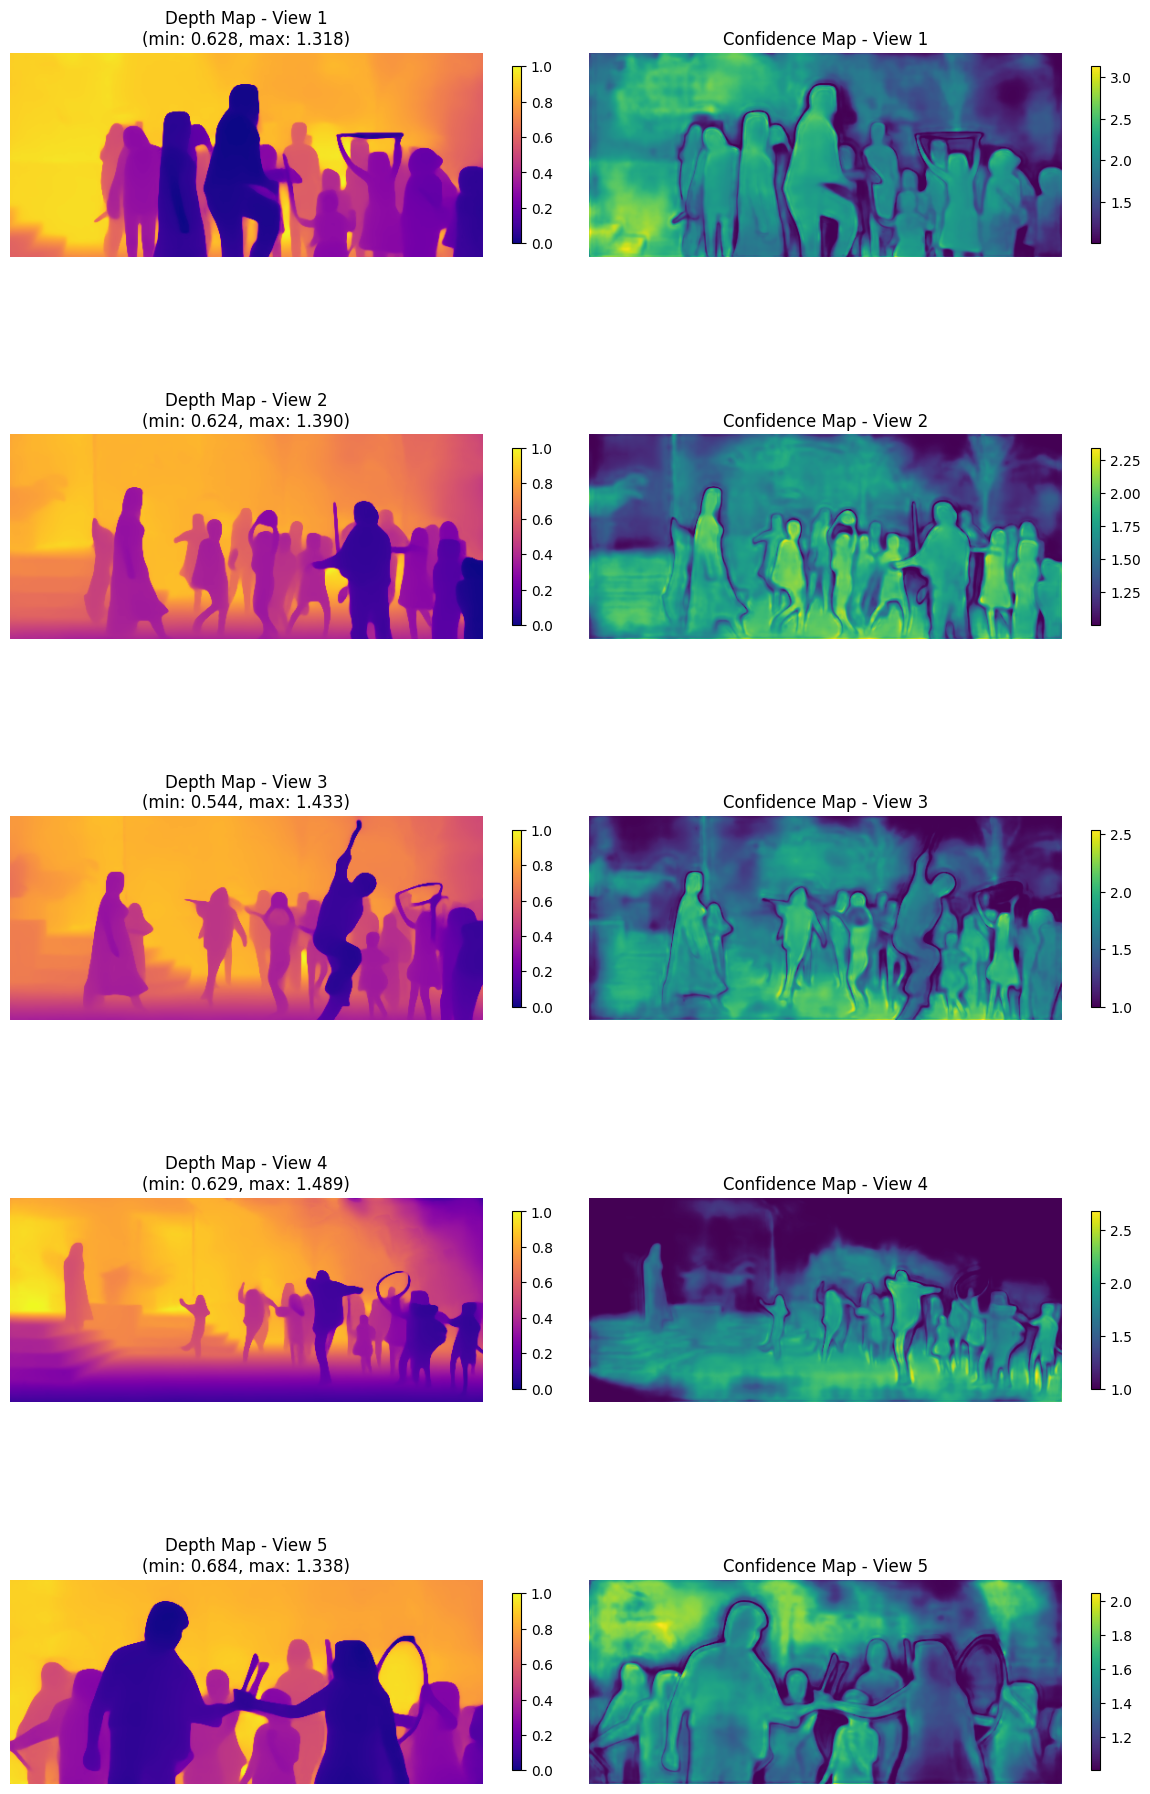

Depth maps saved to: depth_maps.npy
Depth Map Statistics:
Shape: torch.Size([1, 5, 224, 518, 1])
Min depth: 0.544
Max depth: 1.489
Mean depth: 1.055
Std depth: 0.217


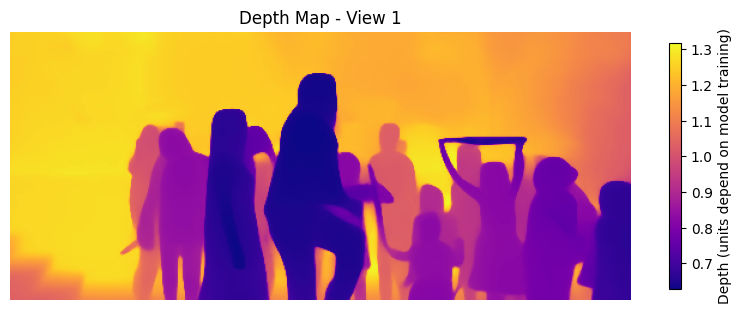

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# First, let's add a debugging function to understand the tensor shapes
def debug_tensor_info(depth_map, depth_conf=None):
    """Debug function to understand tensor shapes and values"""
    print("=== TENSOR DEBUG INFO ===")
    print(f"Depth map shape: {depth_map.shape}")
    print(f"Depth map dtype: {depth_map.dtype}")
    print(f"Depth map device: {depth_map.device}")
    print(f"Depth map min: {depth_map.min().item():.4f}")
    print(f"Depth map max: {depth_map.max().item():.4f}")
    print(f"Depth map mean: {depth_map.mean().item():.4f}")

    if depth_conf is not None:
        print(f"Confidence map shape: {depth_conf.shape}")
        print(f"Confidence map min: {depth_conf.min().item():.4f}")
        print(f"Confidence map max: {depth_conf.max().item():.4f}")
    print("========================")

# Add this before the visualization functions

# Add this after your depth prediction code
def visualize_depth_maps(depth_map, depth_conf=None, save_path=None):
    """
    Visualize predicted depth maps from VGGT model

    Args:
        depth_map: Tensor containing depth values (flexible shape)
        depth_conf: Optional confidence maps
        save_path: Optional path to save the visualization
    """
    # Convert to numpy and move to CPU
    depth_np = depth_map.detach().cpu().numpy()

    # Print shape for debugging
    print(f"Depth map shape: {depth_np.shape}")

    # Handle different tensor shapes
    if len(depth_np.shape) == 2:
        # Single depth map: (H, W)
        depth_np = depth_np[None, None, :, :]  # Add batch and view dims
        batch_size, num_views, height, width = depth_np.shape
    elif len(depth_np.shape) == 3:
        # Either (batch, H, W) or (num_views, H, W)
        depth_np = depth_np[None, :, :, :]  # Add batch dim
        batch_size, num_views, height, width = depth_np.shape
    elif len(depth_np.shape) == 4:
        # Expected: (batch, num_views, H, W)
        batch_size, num_views, height, width = depth_np.shape
    elif len(depth_np.shape) == 5:
        # VGGT format: (batch, num_views, H, W, channels)
        # Squeeze out the channel dimension (assumed to be 1)
        depth_np = depth_np.squeeze(-1)  # Remove last dimension
        batch_size, num_views, height, width = depth_np.shape
        print(f"Squeezed channel dimension: {depth_np.shape}")
    else:
        raise ValueError(f"Unexpected depth map shape: {depth_np.shape}")

    print(f"Processed shape: batch={batch_size}, views={num_views}, H={height}, W={width}")

    # Create subplot grid
    fig, axes = plt.subplots(num_views, 2 if depth_conf is not None else 1,
                            figsize=(12 if depth_conf is not None else 6, 4 * num_views))

    if num_views == 1:
        axes = axes.reshape(1, -1) if depth_conf is not None else [axes]

    for view_idx in range(num_views):
        depth_view = depth_np[0, view_idx]  # Take first batch

        # Normalize depth for better visualization
        depth_min, depth_max = depth_view.min(), depth_view.max()
        depth_normalized = (depth_view - depth_min) / (depth_max - depth_min + 1e-8)

        # Plot depth map
        ax_idx = 0 if depth_conf is None else 0
        current_ax = axes[view_idx][ax_idx] if num_views > 1 else axes[ax_idx]

        im1 = current_ax.imshow(depth_normalized, cmap='plasma', aspect='equal')
        current_ax.set_title(f'Depth Map - View {view_idx + 1}\n(min: {depth_min:.3f}, max: {depth_max:.3f})')
        current_ax.axis('off')
        plt.colorbar(im1, ax=current_ax, shrink=0.4)

        # Plot confidence map if available
        if depth_conf is not None:
            conf_np = depth_conf.detach().cpu().numpy()
            conf_view = conf_np[0, view_idx]

            current_ax = axes[view_idx][1] if num_views > 1 else axes[1]
            im2 = current_ax.imshow(conf_view, cmap='viridis', aspect='equal')
            current_ax.set_title(f'Confidence Map - View {view_idx + 1}')
            current_ax.axis('off')
            plt.colorbar(im2, ax=current_ax, shrink=0.4)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Depth visualization saved to: {save_path}")

    plt.show()

def save_depth_as_numpy(depth_map, save_path):
    """Save depth map as numpy array for further processing"""
    depth_np = depth_map.detach().cpu().numpy()
    np.save(save_path, depth_np)
    print(f"Depth maps saved to: {save_path}")

# Usage after your VGGT prediction code:

# First, debug the tensor shapes
debug_tensor_info(depth_map, depth_conf)

# Then visualize the depth maps
visualize_depth_maps(depth_map, depth_conf, save_path="depth_visualization.png")

# Alternative: Simple visualization that works with any shape
# simple_depth_viz(depth_map)

# Save raw depth data
save_depth_as_numpy(depth_map, "depth_maps.npy")

# Additional analysis
print("Depth Map Statistics:")
print(f"Shape: {depth_map.shape}")
print(f"Min depth: {depth_map.min().item():.3f}")
print(f"Max depth: {depth_map.max().item():.3f}")
print(f"Mean depth: {depth_map.mean().item():.3f}")
print(f"Std depth: {depth_map.std().item():.3f}")

# View individual depth map
def show_single_depth(depth_map, view_idx=0):
    """Show a single depth map with detailed colorbar"""
    depth_single = depth_map[0, view_idx].detach().cpu().numpy()

    plt.figure(figsize=(10, 8))
    im = plt.imshow(depth_single, cmap='plasma', aspect='equal')
    plt.title(f'Depth Map - View {view_idx + 1}')
    plt.colorbar(im, label='Depth (units depend on model training)', shrink=0.4)
    plt.axis('off')
    plt.show()

# Simple fallback visualization for any tensor shape
def simple_depth_viz(depth_tensor):
    """Simple visualization that works with any reasonable tensor shape"""
    depth_np = depth_tensor.detach().cpu().numpy()

    # Flatten to 2D if needed
    if len(depth_np.shape) > 2:
        # Take the first slice along each extra dimension
        while len(depth_np.shape) > 2:
            depth_np = depth_np[0]

    plt.figure(figsize=(10, 8))
    plt.imshow(depth_np, cmap='plasma', aspect='equal')
    plt.title(f'Depth Map (Shape: {depth_tensor.shape})')
    plt.colorbar(label='Depth', shrink=0.4)
    plt.axis('off')
    plt.show()

    print(f"Displayed depth map with original shape: {depth_tensor.shape}")
    print(f"Min: {depth_tensor.min():.4f}, Max: {depth_tensor.max():.4f}")

# Show first view
show_single_depth(depth_map, view_idx=0)